In [ ]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
!pip install -qq fancyimpute

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.22.3 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
black 21.7b0 requires tomli<2.0.0,>=0.2.6, but you have tomli 2.0.1 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.


## Importing Necessary Packages

Let's import the necessary packages

In [ ]:
import pandas as pd
import numpy as np
from fancyimpute import KNN
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

Now I read the data using pandas and then do some preprocessing steps on data before feeding the data into the model and gain insights about the data.

In [ ]:
data = pd.read_csv("data/video_games.csv")
data.head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False
3,DayZ,"Dec 13, 2018",Bohemia Interactive,NaN,$44.99,61%,167115.0,True,False
4,EVE Online,"May 6, 2003",CCP,NaN,Free,74%,11481.0,True,False


it seems that in **original_price** column, there are mixed type data and in the **percent_positive** column, there is a `$` sign with the numerical value. We have to fix this.

In [ ]:
data.isnull().sum()

name                   16
release_date         3179
developer             343
achievements        28639
original_price       5311
percent_positive    23470
num_reviews         23470
multiplayer           520
mature                  0
dtype: int64

<AxesSubplot:>

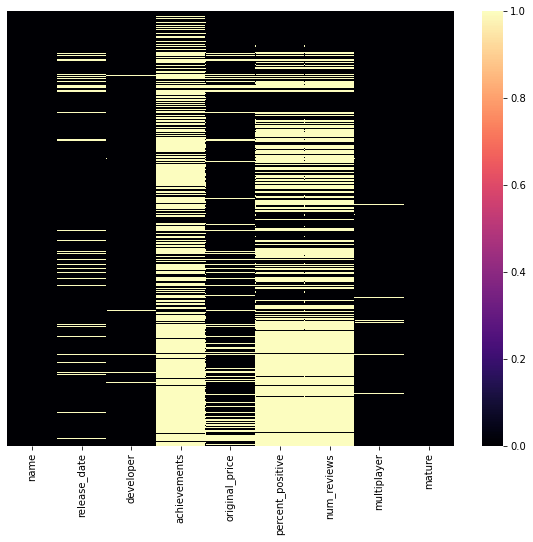

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(data.isnull(), cmap='magma', yticklabels=False)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              40817 non-null  object 
 1   release_date      37654 non-null  object 
 2   developer         40490 non-null  object 
 3   achievements      12194 non-null  float64
 4   original_price    35522 non-null  object 
 5   percent_positive  17363 non-null  object 
 6   num_reviews       17363 non-null  float64
 7   multiplayer       40313 non-null  object 
 8   mature            40833 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.5+ MB


In [ ]:
data['original_price'].unique()[:50]

array(['$19.99', '$29.99', '$39.99', '$44.99', 'Free', nan, '$59.99',
       '$14.99', '$49.99', 'Free to Play', '1.020', 'Free To Play',
       '$9.99', '$12.99', '$57.91', '$7.99', '$6.99', '$24.99',
       'Demo Middle-earth™: Shadow of War™', 'Play for Free!', '$13.99',
       '$59.98', '$69.99', '$76.95', '$84.97', '$58.89', '$8.99',
       '$75.95', '$34.99', '$151.89', '$4.99', '$84.93', '$86.92',
       '$20.00', '$15.99', '$9.98',
       'Shadow of the Tomb Raider Free Trial', '$5.99', '$11.99',
       '$32.98', '$21.98',
       'FINAL FANTASY XV WINDOWS EDITION PLAYABLE DEMO', '$28.00', 'UNO',
       '$79.99', '$59.95', '$3.99', '$30.00', '$17.99', '$57.98'],
      dtype=object)

Now this is the time for drop some columns. **release_date** and **achievements** neither matters for searching for a game nor determining the genre. and for now, I am removing the **original_price** column for simplicity.

In [ ]:
data.drop(['release_date', 'achievements', 'original_price'], axis=1, inplace=True)
data.head()

,name,developer,percent_positive,num_reviews,multiplayer,mature
0,DOOM,id Software,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,49%,836608.0,True,True
2,BATTLETECH,Harebrained Schemes,71%,7030.0,True,False
3,DayZ,Bohemia Interactive,61%,167115.0,True,False
4,EVE Online,CCP,74%,11481.0,True,False


### Removing the null values names and other null featured column

Now we can see from the above result, we can see that there are so much null values in the data. So for better imputation I am using the **KNearestNeighbors** algorithm from fancyimpute package. But before doing that, I want to remove some of the null values:

- rows containing **name** columns as null, because this make no sense for imputing those using **KNN**.
- rows containing **developer**, **percent_positive**, **num_reviews**, **multiplayer** as null, because those are the main features. Without    those values, **KNN** will unable to find a pattern for replace those values.

In [ ]:
data = data[data['name'].notnull()]
data.shape

(40817, 6)

In [ ]:
mask = data['developer'].isnull() & data['percent_positive'].isnull() & data['num_reviews'].isnull() & data['multiplayer'].isnull()
drop_index = list(data[mask].index)

In [ ]:
data.drop(drop_index, inplace=True)

In [ ]:
data.shape

(40748, 6)

In [ ]:
data['percent_positive'] = data['percent_positive'].str.replace('%', ' ')
data['percent_positive'] = data['percent_positive'].astype('float')

As this is a very Huge dataset, So I have to take a small part of this. I took two part from the data. One for training and one for testing. After that, I encode the categorical variables and impute them.

In [ ]:
data1 = data[:10000]
data2 = data[10000: 20000]
print(data1.shape)
print(data2.shape)

(10000, 6)
(10000, 6)


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_enc_dict1 = {}
cols = ['name', 'developer', 'multiplayer', 'mature']

for col_name in cols:
    
    ordinal_enc_dict1[col_name] = OrdinalEncoder()
    col = data1[col_name]
    
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1, 1)
    encoded_vals = ordinal_enc_dict1[col_name].fit_transform(reshaped_vals)
    
    data1.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)
    
    
ordinal_enc_dict2 = {}
cols = ['name', 'developer', 'multiplayer', 'mature']

for col_name in cols:
    
    ordinal_enc_dict2[col_name] = OrdinalEncoder()
    col = data2[col_name]
    
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1, 1)
    encoded_vals = ordinal_enc_dict2[col_name].fit_transform(reshaped_vals)
    
    data2.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

In [ ]:
data1.head(10)

,name,developer,percent_positive,num_reviews,multiplayer,mature
0,1862.0,5393.0,92.0,42550.0,1.0,0.0
1,5916.0,3409.0,49.0,836608.0,1.0,1.0
2,666.0,2003.0,71.0,7030.0,1.0,0.0
3,1998.0,641.0,61.0,167115.0,1.0,0.0
4,2529.0,733.0,74.0,11481.0,1.0,0.0
5,3489.0,3904.0,NaN,NaN,1.0,0.0
6,2190.0,727.0,92.0,9645.0,1.0,1.0
7,3984.0,3229.0,91.0,23763.0,1.0,0.0
8,8611.0,3273.0,85.0,12127.0,0.0,0.0
9,9369.0,1416.0,44.0,904.0,1.0,1.0


In [ ]:
data2.head()

,name,developer,percent_positive,num_reviews,multiplayer,mature
10007,8304.0,2215.0,NaN,NaN,0.0,0.0
10008,3940.0,2066.0,NaN,NaN,0.0,0.0
10009,4306.0,522.0,100.0,18.0,0.0,0.0
10010,8901.0,5624.0,NaN,NaN,0.0,0.0
10011,3117.0,3990.0,NaN,NaN,0.0,0.0


In [ ]:
# !pip install -qq fancyimpute

In [ ]:
from fancyimpute import KNN

KNN_imputer = KNN()

data1.iloc[:, :] = np.round(KNN_imputer.fit_transform(data1))

for col_name in cols:

    # Reshape the data
    reshaped = data1[col_name].values.reshape(-1, 1)

    # Perform inverse transform of the ordinally encoded columns
    data1[col_name] = ordinal_enc_dict1[col_name].inverse_transform(reshaped)

Imputing row 1/10000 with 0 missing, elapsed time: 14.567
Imputing row 101/10000 with 0 missing, elapsed time: 14.570
Imputing row 201/10000 with 0 missing, elapsed time: 14.572
Imputing row 301/10000 with 0 missing, elapsed time: 14.574
Imputing row 401/10000 with 0 missing, elapsed time: 14.576
Imputing row 501/10000 with 0 missing, elapsed time: 14.580
Imputing row 601/10000 with 0 missing, elapsed time: 14.582
Imputing row 701/10000 with 0 missing, elapsed time: 14.584
Imputing row 801/10000 with 0 missing, elapsed time: 14.585
Imputing row 901/10000 with 0 missing, elapsed time: 14.588
Imputing row 1001/10000 with 0 missing, elapsed time: 14.589
Imputing row 1101/10000 with 1 missing, elapsed time: 14.591
Imputing row 1201/10000 with 0 missing, elapsed time: 14.594
Imputing row 1301/10000 with 0 missing, elapsed time: 14.596
Imputing row 1401/10000 with 2 missing, elapsed time: 14.598
Imputing row 1501/10000 with 0 missing, elapsed time: 14.600
Imputing row 1601/10000 with 0 missi

In [ ]:
data2.iloc[:, :] = np.round(KNN_imputer.fit_transform(data2))

for col_name in cols:

    # Reshape the data
    reshaped = data2[col_name].values.reshape(-1, 1)

    # Perform inverse transform of the ordinally encoded columns
    data2[col_name] = ordinal_enc_dict2[col_name].inverse_transform(reshaped)

Imputing row 1/10000 with 2 missing, elapsed time: 14.980
Imputing row 101/10000 with 0 missing, elapsed time: 14.993
Imputing row 201/10000 with 2 missing, elapsed time: 15.006
Imputing row 301/10000 with 2 missing, elapsed time: 15.020
Imputing row 401/10000 with 2 missing, elapsed time: 15.035
Imputing row 501/10000 with 2 missing, elapsed time: 15.050
Imputing row 601/10000 with 2 missing, elapsed time: 15.062
Imputing row 701/10000 with 2 missing, elapsed time: 15.075
Imputing row 801/10000 with 2 missing, elapsed time: 15.089
Imputing row 901/10000 with 2 missing, elapsed time: 15.104
Imputing row 1001/10000 with 2 missing, elapsed time: 15.118
Imputing row 1101/10000 with 2 missing, elapsed time: 15.133
Imputing row 1201/10000 with 2 missing, elapsed time: 15.148
Imputing row 1301/10000 with 2 missing, elapsed time: 15.163
Imputing row 1401/10000 with 2 missing, elapsed time: 15.177
Imputing row 1501/10000 with 2 missing, elapsed time: 15.192
Imputing row 1601/10000 with 2 missi

In [ ]:
data1.head()

,name,developer,percent_positive,num_reviews,multiplayer,mature
0,DOOM,id Software,92.0,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,49.0,836608.0,True,True
2,BATTLETECH,Harebrained Schemes,71.0,7030.0,True,False
3,DayZ,Bohemia Interactive,61.0,167115.0,True,False
4,EVE Online,CCP,74.0,11481.0,True,False


In [ ]:
data2.head()

,name,developer,percent_positive,num_reviews,multiplayer,mature
10007,The Harbinger's Head,Hosted Games,90.0,24.0,False,False
10008,HyperZen Training,Guillaume Thiolliere,81.0,71.0,False,False
10009,Kilcount,Beatrice,100.0,18.0,False,False
10010,Treasure Hunter Man 2,origamihero games,84.0,29.0,False,False
10011,Fitzzle Wise Owls,Red Dolphin Games,72.0,11.0,False,False


In [ ]:
data1.isnull().sum()

name                0
developer           0
percent_positive    0
num_reviews         0
multiplayer         0
mature              0
dtype: int64

In [ ]:
data2.isnull().sum()

name                0
developer           0
percent_positive    0
num_reviews         0
multiplayer         0
mature              0
dtype: int64

## Time for Modelling

After imputing all the values and verifying them, now it is time for modelling. According to the problem we have to classify into categories using clustering techniques. I am using **KMeans Clustering** here. before feed this data into the model, again we have to encode it.

In [ ]:
ordinal_enc = OrdinalEncoder()

for col_name in cols:
    reshaped1 = data1[col_name].values.reshape(-1,1)
    reshaped2 = data2[col_name].values.reshape(-1,1)
    data1[col_name] = ordinal_enc.fit_transform(reshaped1)
    data2[col_name] = ordinal_enc.fit_transform(reshaped2)

### Applying PCA

Now I am going to extract the important features using Principal Component Analysis aka PCA. Without this, KMeans works very bad in clustering the data.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca=PCA(n_components=2)
pca_comp=pca.fit_transform(data1)
pca_comp_test=pca.transform(data2)

In [ ]:
pca_comp.shape

(10000, 2)

In [ ]:
pca_comp_test.shape

(10000, 2)

### Determining the Number of Clusters

Now there is a question that how to determine the number of clusters in kmeans. there is two methods for this - **silhoutte score** and **elbow method**. I am using Elbow method here. In this method, we have to plot a graph on different inertias based on different cluster numbers. we have to choose a cluster number from where there is minimal change in values. as this graph seems to be a human's elbow, so this method name is elbow method.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_per_k=[KMeans(n_clusters=k,init='k-means++',n_init=15).fit(pca_comp) for k in range(1,6)]
inertias=[model.inertia_ for model in kmeans_per_k]

In [ ]:
import matplotlib.pyplot as plt

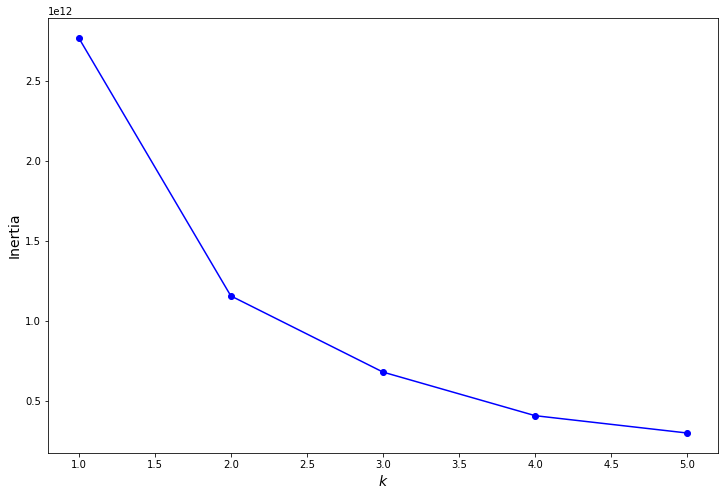

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(1,6),inertias,"bo-")
plt.xlabel("$k$",fontsize=14)
plt.ylabel('Inertia',fontsize=14)
plt.show()

from this graph we can clearly see that 2 is the desired cluster number.

In [ ]:
kmeans=KMeans(n_clusters=2,n_init=15)
pred=kmeans.fit_predict(pca_comp)

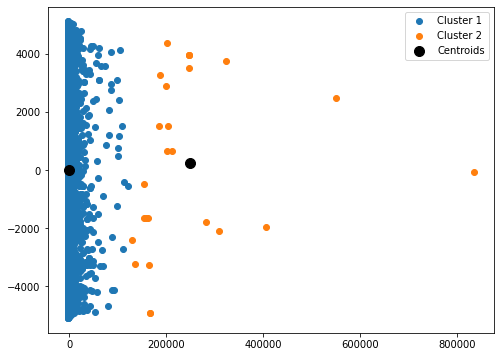

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(pca_comp[pred==0,0], pca_comp[pred==0,1],label='Cluster 1')
plt.scatter(pca_comp[pred==1,0], pca_comp[pred==1,1],label='Cluster 2')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,c='black',label='Centroids')
plt.legend()
plt.show()

after training the model on 2 clusters and predicting on the training set, this is the result the machine cluster the games in two sections. though i don't include the price column here, machine still cluster them into two parts. Let's see the results in the testing set.

In [ ]:
pred2 = kmeans.predict(pca_comp_test)

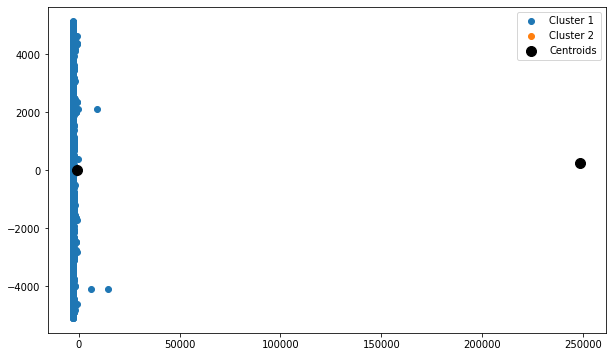

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pca_comp_test[pred2==0,0], pca_comp_test[pred2==0,1],label='Cluster 1')
plt.scatter(pca_comp_test[pred2==1,0], pca_comp_test[pred2==1,1],label='Cluster 2')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,c='black',label='Centroids')
plt.legend()
plt.show()

here also the games are divided into the two clusters but the data points are missing for the cluster 2. It may happen that the testing set contains only those datapoints related to cluster 1.

## Outcome:

From the above two plots we can clearly say that the model sucessfully make distinction between the two categories. the number of categories is 2 which is lesser than 5, so there is no difficulty for fitting into the platform homepage anymore.

## Future Improvements:

This model can be improved by considering the **original_price** column. For limited computational resources, I have to take a sample of the data and have to work on them. If I can take the whole data for model training, this model can be much accurate in clustering the data. there is also a scope for feature engineering like making a new column **positive_review** using **positive_percent** and **num_reviews** column.